In [1]:
# get the dataset from here: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [3]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"


In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

/home/saiteja/Desktop/pruning/intel_dataset/seg_train/seg_train


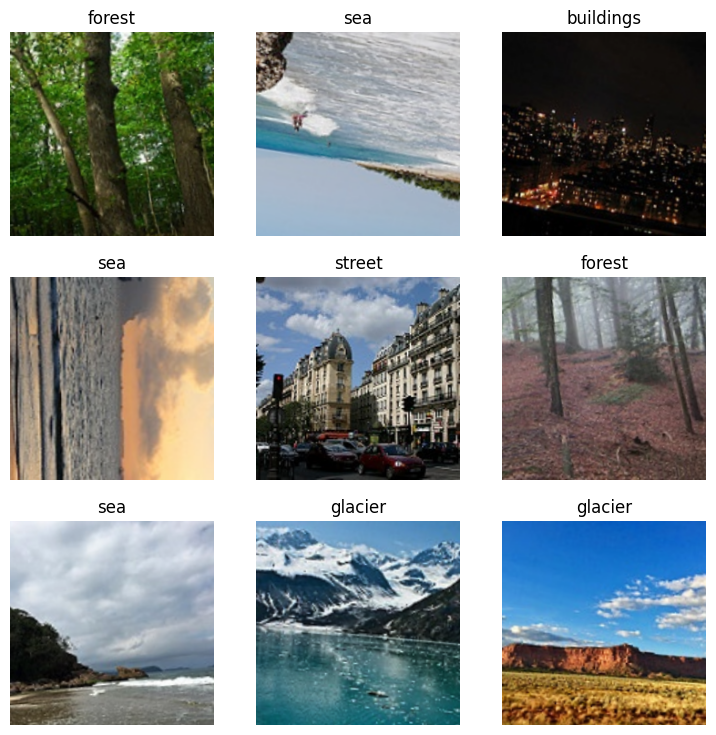

In [17]:
# train the model using fastai
import os
import fiftyone as fo

split = 'train'
DATASET_DIR = f'/home/saiteja/Desktop/pruning/intel_dataset/seg_{split}/seg_{split}'

print(DATASET_DIR)

import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]
batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [23]:
import timm
from fastai.vision.all import *

# Create the Learner
learner = cnn_learner(data, 'resnet18', metrics=[accuracy])

# Fine-tune the model
learner.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.733985,0.342292,0.879900,00:48


epoch,train_loss,valid_loss,accuracy,time
0,0.516826,0.282877,0.898432,01:03
1,0.465034,0.275218,0.904134,01:03


In [24]:
torch.save(learner.model, 'models/resnet18.pth')

In [25]:
# Load the entire model
model = torch.load('models/resnet18.pth')

# Make sure the model is in evaluation mode if you're doing inference
model.eval()

# If using GPU, move the model to the correct device
model = model.cuda()  # If you want to run on a GPU

In [31]:
# to get to know about the parameters of the model
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [32]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, RandomCrop, RandomHorizontalFlip, ToTensor
from torchvision.datasets import ImageFolder

# Define the image size for ResNet18
image_size = 224  # ResNet18 expects 224x224 input size

from PIL import Image

transforms_dict = dict()


def check_image_size(image):
    if image.size != (image_size, image_size):
        print(f"Image size mismatch: {image.size}")
    return image

# Modify the transforms to include the check
transforms_dict["train"] = Compose([
    Resize((image_size, image_size)),
    RandomCrop(image_size, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
])

transforms_dict["test"] = Compose([
    Resize((image_size, image_size)),
    ToTensor(),
])

# Define the dataset
dataset = {}
for split in ["train", "test"]:
    dataset[split] = ImageFolder(
        root=f"/home/saiteja/Desktop/pruning/intel_dataset/seg_{split}/seg_{split}",
        transform=transforms_dict[split]
    )

# Create DataLoader
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=32,  # You can adjust this batch size based on your system's capacity
        shuffle=(split == 'train'),
        num_workers=4,  # Set this to an appropriate value based on your machine's capability
        pin_memory=True
    )

# Now you can use the dataloaders like this:
# for images, labels in dataloader['train']:
#     # Train your model here


In [33]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()


@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [46]:
import torch
num_finetune_epochs = 5
import timm

# Load the entire model
model = torch.load('models/resnet18.pth')

# Make sure the model is in evaluation mode if you're doing inference
model.eval()

# If using GPU, move the model to the correct device
model = model.cuda()  # If you want to run on a GPU

# model = timm.create_model('resnet34', num_classes = 6).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

# for epoch_ in range(num_finetune_epochs):
#     train(model, dataloader['train'], criterion, optimizer, scheduler)

dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")


dense model has accuracy=71.13%
dense model has size=44.66 MiB


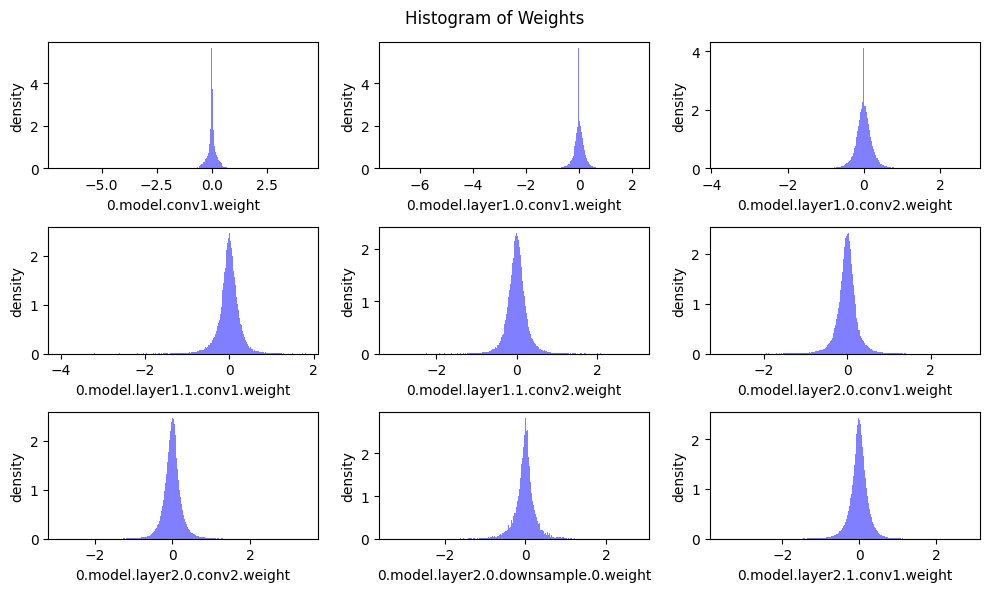

In [47]:

def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and plot_index<9:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

In [48]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [49]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):


        # running on only conv
        if 'conv' not in name: continue

        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)

    return sparsities, accuracies

In [50]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/22 weight - 0.model.conv1.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.22s/it]

    sparsity=0.40: accuracy=64.00%

scanning 0/22 weight - 0.model.conv1.weight:  33%|███▎      | 2/6 [00:10<00:20,  5.19s/it]

    sparsity=0.50: accuracy=68.50%

scanning 0/22 weight - 0.model.conv1.weight:  50%|█████     | 3/6 [00:15<00:15,  5.17s/it]

    sparsity=0.60: accuracy=58.00%

scanning 0/22 weight - 0.model.conv1.weight:  67%|██████▋   | 4/6 [00:20<00:10,  5.17s/it]

    sparsity=0.70: accuracy=44.70%

scanning 0/22 weight - 0.model.conv1.weight:  83%|████████▎ | 5/6 [00:25<00:05,  5.17s/it]

    sparsity=0.80: accuracy=18.70%

scanning 0/22 weight - 0.model.conv1.weight: 100%|██████████| 6/6 [00:31<00:00,  5.18s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[64.00%, 68.50%, 58.00%, 44.70%, 18.70%, 16.10%]

scanning 1/22 weight - 0.model.layer1.0.conv1.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.28s/it]

    sparsity=0.40: accuracy=53.33%

scanning 1/22 weight - 0.model.layer1.0.conv1.weight:  33%|███▎      | 2/6 [00:10<00:21,  5.29s/it]

    sparsity=0.50: accuracy=34.73%

scanning 1/22 weight - 0.model.layer1.0.conv1.weight:  50%|█████     | 3/6 [00:15<00:15,  5.27s/it]

    sparsity=0.60: accuracy=21.27%

scanning 1/22 weight - 0.model.layer1.0.conv1.weight:  67%|██████▋   | 4/6 [00:21<00:10,  5.25s/it]

    sparsity=0.70: accuracy=18.47%

scanning 1/22 weight - 0.model.layer1.0.conv1.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.24s/it]

    sparsity=0.80: accuracy=17.53%

scanning 1/22 weight - 0.model.layer1.0.conv1.weight: 100%|██████████| 6/6 [00:31<00:00,  5.26s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[53.33%, 34.73%, 21.27%, 18.47%, 17.53%, 18.67%]

scanning 2/22 weight - 0.model.layer1.0.conv2.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.21s/it]

    sparsity=0.40: accuracy=71.63%

scanning 2/22 weight - 0.model.layer1.0.conv2.weight:  33%|███▎      | 2/6 [00:10<00:20,  5.21s/it]

    sparsity=0.50: accuracy=64.40%

scanning 2/22 weight - 0.model.layer1.0.conv2.weight:  50%|█████     | 3/6 [00:15<00:15,  5.24s/it]

    sparsity=0.60: accuracy=56.83%

scanning 2/22 weight - 0.model.layer1.0.conv2.weight:  67%|██████▋   | 4/6 [00:20<00:10,  5.24s/it]

    sparsity=0.70: accuracy=38.23%

scanning 2/22 weight - 0.model.layer1.0.conv2.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.24s/it]

    sparsity=0.80: accuracy=24.70%

scanning 2/22 weight - 0.model.layer1.0.conv2.weight: 100%|██████████| 6/6 [00:31<00:00,  5.23s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.63%, 64.40%, 56.83%, 38.23%, 24.70%, 22.43%]

scanning 3/22 weight - 0.model.layer1.1.conv1.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.21s/it]

    sparsity=0.40: accuracy=42.23%

scanning 3/22 weight - 0.model.layer1.1.conv1.weight:  33%|███▎      | 2/6 [00:10<00:20,  5.22s/it]

    sparsity=0.50: accuracy=35.43%

scanning 3/22 weight - 0.model.layer1.1.conv1.weight:  50%|█████     | 3/6 [00:15<00:15,  5.21s/it]

    sparsity=0.60: accuracy=14.43%

scanning 3/22 weight - 0.model.layer1.1.conv1.weight:  67%|██████▋   | 4/6 [00:20<00:10,  5.20s/it]

    sparsity=0.70: accuracy=17.27%

scanning 3/22 weight - 0.model.layer1.1.conv1.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.20s/it]

    sparsity=0.80: accuracy=17.57%

scanning 3/22 weight - 0.model.layer1.1.conv1.weight: 100%|██████████| 6/6 [00:31<00:00,  5.21s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[42.23%, 35.43%, 14.43%, 17.27%, 17.57%, 19.57%]

scanning 4/22 weight - 0.model.layer1.1.conv2.weight:  17%|█▋        | 1/6 [00:05<00:27,  5.45s/it]

    sparsity=0.40: accuracy=68.97%

scanning 4/22 weight - 0.model.layer1.1.conv2.weight:  33%|███▎      | 2/6 [00:11<00:22,  5.58s/it]

    sparsity=0.50: accuracy=63.80%

scanning 4/22 weight - 0.model.layer1.1.conv2.weight:  50%|█████     | 3/6 [00:16<00:16,  5.53s/it]

    sparsity=0.60: accuracy=67.30%

scanning 4/22 weight - 0.model.layer1.1.conv2.weight:  67%|██████▋   | 4/6 [00:21<00:10,  5.44s/it]

    sparsity=0.70: accuracy=54.93%

scanning 4/22 weight - 0.model.layer1.1.conv2.weight:  83%|████████▎ | 5/6 [00:27<00:05,  5.43s/it]

    sparsity=0.80: accuracy=57.40%

scanning 4/22 weight - 0.model.layer1.1.conv2.weight: 100%|██████████| 6/6 [00:32<00:00,  5.46s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[68.97%, 63.80%, 67.30%, 54.93%, 57.40%, 42.67%]

scanning 5/22 weight - 0.model.layer2.0.conv1.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.27s/it]

    sparsity=0.40: accuracy=73.17%

scanning 5/22 weight - 0.model.layer2.0.conv1.weight:  33%|███▎      | 2/6 [00:10<00:20,  5.24s/it]

    sparsity=0.50: accuracy=72.07%

scanning 5/22 weight - 0.model.layer2.0.conv1.weight:  50%|█████     | 3/6 [00:15<00:15,  5.25s/it]

    sparsity=0.60: accuracy=71.53%

scanning 5/22 weight - 0.model.layer2.0.conv1.weight:  67%|██████▋   | 4/6 [00:21<00:10,  5.29s/it]

    sparsity=0.70: accuracy=63.93%

scanning 5/22 weight - 0.model.layer2.0.conv1.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.37s/it]

    sparsity=0.80: accuracy=36.07%

scanning 5/22 weight - 0.model.layer2.0.conv1.weight: 100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.17%, 72.07%, 71.53%, 63.93%, 36.07%, 24.73%]

scanning 6/22 weight - 0.model.layer2.0.conv2.weight:  17%|█▋        | 1/6 [00:05<00:28,  5.60s/it]

    sparsity=0.40: accuracy=70.63%

scanning 6/22 weight - 0.model.layer2.0.conv2.weight:  33%|███▎      | 2/6 [00:11<00:23,  5.78s/it]

    sparsity=0.50: accuracy=69.13%

scanning 6/22 weight - 0.model.layer2.0.conv2.weight:  50%|█████     | 3/6 [00:17<00:17,  5.77s/it]

    sparsity=0.60: accuracy=68.90%

scanning 6/22 weight - 0.model.layer2.0.conv2.weight:  67%|██████▋   | 4/6 [00:22<00:11,  5.72s/it]

    sparsity=0.70: accuracy=67.20%

scanning 6/22 weight - 0.model.layer2.0.conv2.weight:  83%|████████▎ | 5/6 [00:28<00:05,  5.71s/it]

    sparsity=0.80: accuracy=59.07%

scanning 6/22 weight - 0.model.layer2.0.conv2.weight: 100%|██████████| 6/6 [00:34<00:00,  5.72s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.63%, 69.13%, 68.90%, 67.20%, 59.07%, 50.10%]

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight:  17%|█▋        | 1/6 [00:05<00:29,  5.95s/it]

    sparsity=0.40: accuracy=70.93%

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight:  33%|███▎      | 2/6 [00:11<00:23,  5.90s/it]

    sparsity=0.50: accuracy=66.40%

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight:  50%|█████     | 3/6 [00:17<00:17,  5.68s/it]

    sparsity=0.60: accuracy=63.60%

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight:  67%|██████▋   | 4/6 [00:22<00:11,  5.67s/it]

    sparsity=0.70: accuracy=58.10%

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight:  83%|████████▎ | 5/6 [00:28<00:05,  5.76s/it]

    sparsity=0.80: accuracy=37.63%

scanning 7/22 weight - 0.model.layer2.0.downsample.0.weight: 100%|██████████| 6/6 [00:34<00:00,  5.77s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[70.93%, 66.40%, 63.60%, 58.10%, 37.63%, 30.37%]

scanning 8/22 weight - 0.model.layer2.1.conv1.weight:  17%|█▋        | 1/6 [00:05<00:28,  5.75s/it]

    sparsity=0.40: accuracy=73.27%

scanning 8/22 weight - 0.model.layer2.1.conv1.weight:  33%|███▎      | 2/6 [00:11<00:22,  5.68s/it]

    sparsity=0.50: accuracy=69.17%

scanning 8/22 weight - 0.model.layer2.1.conv1.weight:  50%|█████     | 3/6 [00:17<00:17,  5.69s/it]

    sparsity=0.60: accuracy=65.53%

scanning 8/22 weight - 0.model.layer2.1.conv1.weight:  67%|██████▋   | 4/6 [00:22<00:11,  5.69s/it]

    sparsity=0.70: accuracy=47.93%

scanning 8/22 weight - 0.model.layer2.1.conv1.weight:  83%|████████▎ | 5/6 [00:28<00:05,  5.69s/it]

    sparsity=0.80: accuracy=28.03%

scanning 8/22 weight - 0.model.layer2.1.conv1.weight: 100%|██████████| 6/6 [00:34<00:00,  5.67s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.27%, 69.17%, 65.53%, 47.93%, 28.03%, 25.07%]

scanning 9/22 weight - 0.model.layer2.1.conv2.weight:  17%|█▋        | 1/6 [00:05<00:28,  5.61s/it]

    sparsity=0.40: accuracy=71.27%

scanning 9/22 weight - 0.model.layer2.1.conv2.weight:  33%|███▎      | 2/6 [00:10<00:21,  5.43s/it]

    sparsity=0.50: accuracy=69.80%

scanning 9/22 weight - 0.model.layer2.1.conv2.weight:  50%|█████     | 3/6 [00:16<00:16,  5.38s/it]

    sparsity=0.60: accuracy=69.50%

scanning 9/22 weight - 0.model.layer2.1.conv2.weight:  67%|██████▋   | 4/6 [00:21<00:10,  5.36s/it]

    sparsity=0.70: accuracy=70.47%

scanning 9/22 weight - 0.model.layer2.1.conv2.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.39s/it]

    sparsity=0.80: accuracy=69.23%

scanning 9/22 weight - 0.model.layer2.1.conv2.weight: 100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.27%, 69.80%, 69.50%, 70.47%, 69.23%, 60.80%]

scanning 10/22 weight - 0.model.layer3.0.conv1.weight:  17%|█▋        | 1/6 [00:05<00:26,  5.37s/it]

    sparsity=0.40: accuracy=71.47%

scanning 10/22 weight - 0.model.layer3.0.conv1.weight:  33%|███▎      | 2/6 [00:10<00:21,  5.39s/it]

    sparsity=0.50: accuracy=70.83%

scanning 10/22 weight - 0.model.layer3.0.conv1.weight:  50%|█████     | 3/6 [00:16<00:16,  5.37s/it]

    sparsity=0.60: accuracy=66.20%

scanning 10/22 weight - 0.model.layer3.0.conv1.weight:  67%|██████▋   | 4/6 [00:21<00:10,  5.37s/it]

    sparsity=0.70: accuracy=63.50%

scanning 10/22 weight - 0.model.layer3.0.conv1.weight:  83%|████████▎ | 5/6 [00:26<00:05,  5.40s/it]

    sparsity=0.80: accuracy=57.93%

scanning 10/22 weight - 0.model.layer3.0.conv1.weight: 100%|██████████| 6/6 [00:32<00:00,  5.39s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[71.47%, 70.83%, 66.20%, 63.50%, 57.93%, 33.67%]

In [53]:
import torch
num_finetune_epochs = 5
import timm

# Load the entire model
model = torch.load('models/resnet18.pth')

# Make sure the model is in evaluation mode if you're doing inference
model.eval()

# If using GPU, move the model to the correct device
model = model.cuda()  # If you want to run on a GPU

In [77]:
print(np.shape(accuracies))  # Check if it's a 2D array with 9 rows and N sparsity values
print(np.shape(sparsities))  # Check if it matches the number of sparsity values per plot


(11, 6)
(6,)


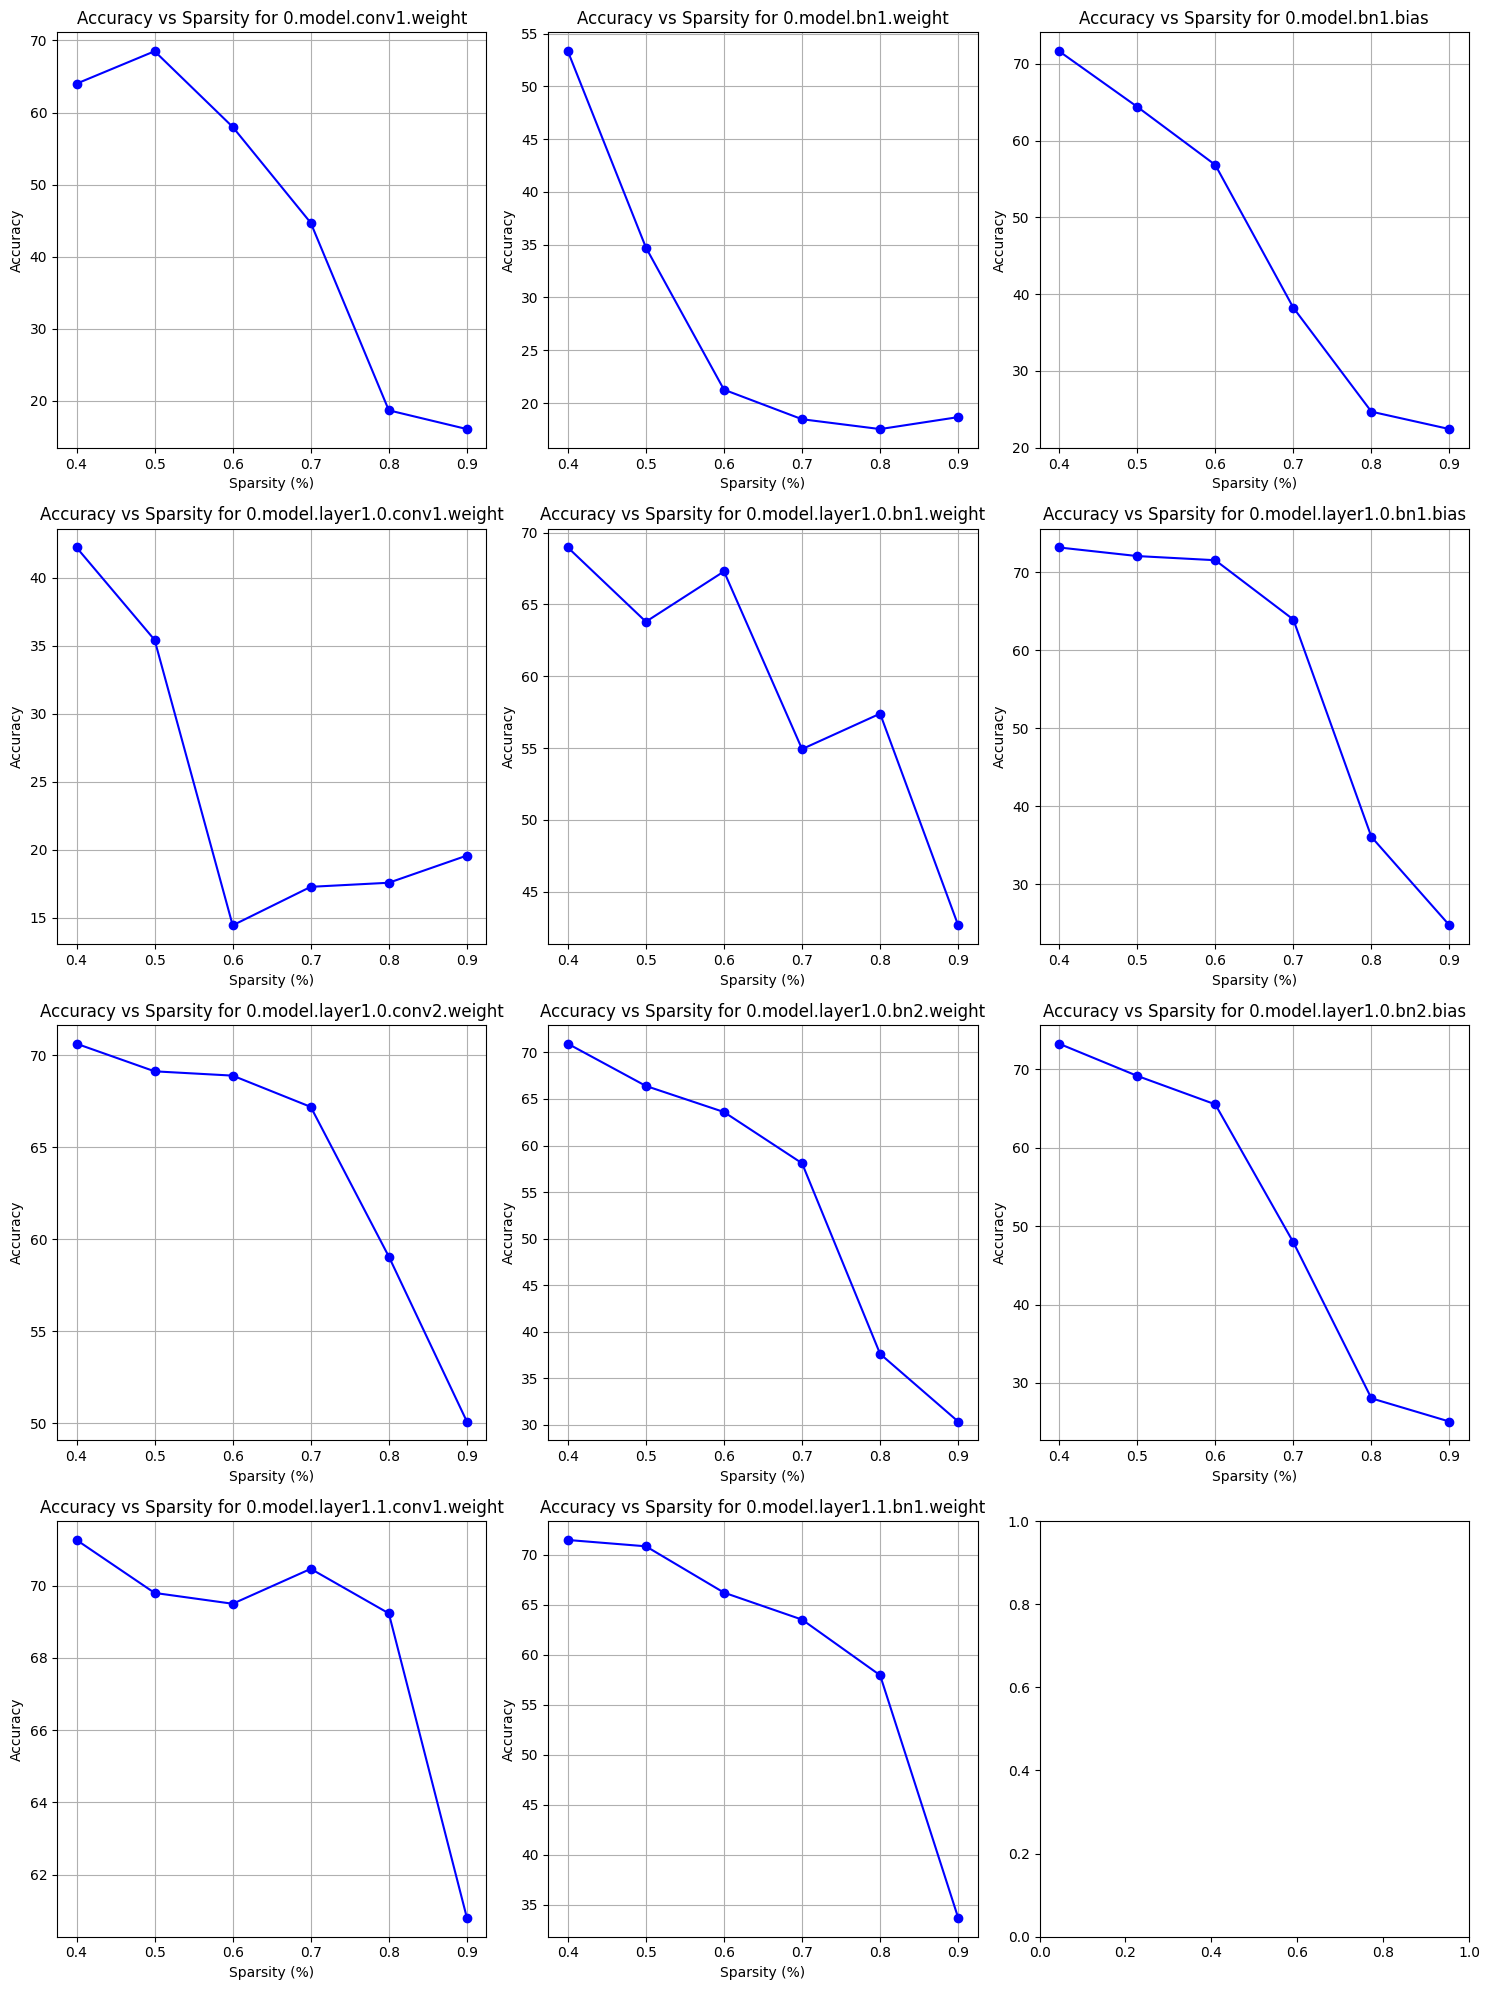

In [83]:
import matplotlib.pyplot as plt

# Ensure that the number of sparsity values matches the number of columns in accuracies
assert accuracies.shape[1] == len(sparsities), "Sparsity values do not match the number of columns in accuracies"

# Convert the named_parameters generator to a list
named_params = list(model.named_parameters())

# Number of layers (subplots)
num_layers = len(named_params)

# Calculate the grid size (number of rows and columns for subplots)
ncols = 3  # Number of columns in the grid (you can adjust this as needed)
nrows = 4  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over the model's named parameters
for idx, (name, param) in enumerate(named_params):

    if idx< 11:
        # Plot accuracies vs sparsities for this layer in the corresponding subplot
        ax = axes[idx]
        ax.plot(sparsities, accuracies[idx], marker='o', linestyle='-', color='b')
        ax.set_title(f'Accuracy vs Sparsity for {name}')
        ax.set_xlabel('Sparsity (%)')
        ax.set_ylabel('Accuracy')
        ax.grid(True)

# Hide any unused subplots if there are more axes than layers
for j in range(num_layers, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()


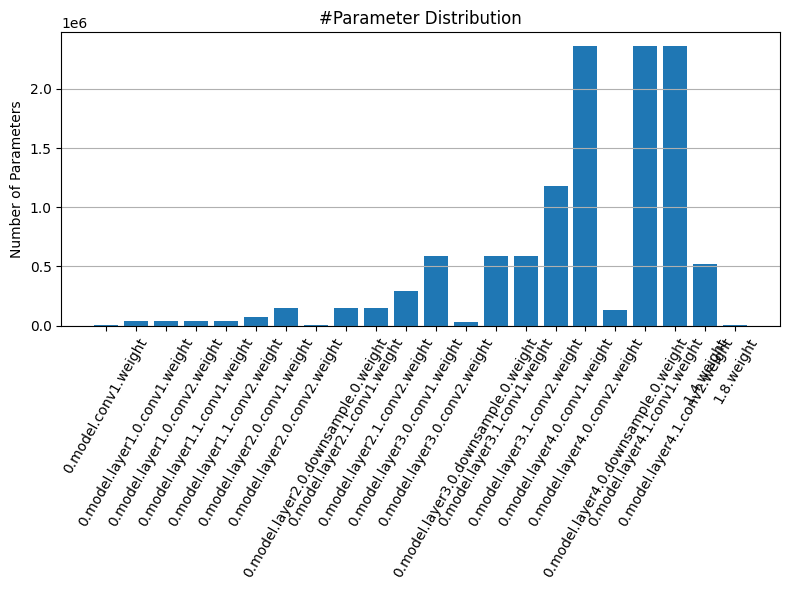

In [84]:

def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [85]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks


In [89]:
for name, param in model.named_parameters():
    # print(name)    
    if 'conv' in name:
        print(name)            

0.model.conv1.weight
0.model.layer1.0.conv1.weight
0.model.layer1.0.conv2.weight
0.model.layer1.1.conv1.weight
0.model.layer1.1.conv2.weight
0.model.layer2.0.conv1.weight
0.model.layer2.0.conv2.weight
0.model.layer2.1.conv1.weight
0.model.layer2.1.conv2.weight
0.model.layer3.0.conv1.weight
0.model.layer3.0.conv2.weight
0.model.layer3.1.conv1.weight
0.model.layer3.1.conv2.weight
0.model.layer4.0.conv1.weight
0.model.layer4.0.conv2.weight
0.model.layer4.1.conv1.weight
0.model.layer4.1.conv2.weight
